## Mini-Projet: Séparation de sources hyperspectrale

Une image hyperspectrale est une image où un spectre contenant $D$ valeurs ou canaux est enregistré à chaque pixel. Cette modalité d'imagerie est très utilisée en imagerie satellitaire, où elle permet d'améliorer considérablement la résolution de la prise d'image. Dans le cas des images satellitaires, les pixels de l'image ont ainsi une résolution spatiale de l'ordre de la dizaine de mètres, de sorte que ces pixels mélangent les contributions des différents éléments présents sur la scène imagée (végétation, eau, minéraux du sol, habitations, routes, etc.). Nous nous intéressons ici à un problème, connu sous le nom de séparation de sources hyperspectrale, qui vise à identifier, pour une observation donnée, les spectres des constituants élémentaires présents dans une scène, ainsi que la proportion ("l'abondance") de ces constituants en chaque pixel de l'image.

L'objectif de ce mini-projet est d'implémenter un algorithme de séparation de source hyperspectral et de l'appliquer à une image satellitaire issue de la base de donnée SAMSON. L'image en question est de taille 95 x 95 pixels. Chaque pixel correspond à un spectre de 156 canaux, qui couvrent un intervalle de longueurs d'onde qui s'étend de 401 à 889 nm. La résolution spectrale est de 3.13 nm. Chaque spectre Y(x, y) mesuré au niveau du pixel (x, y) de l'image correspond à la combinaison linéaire des spectres *élémentaires* associés à l'eau, à la végétation et aux minéraux présents dans le sol:

$$
Y[x, y] = \alpha_{1} [x, y] m_1 + \alpha_2 [x, y] m_2 + (1 - \alpha_1[x, y] - \alpha_2[x, y]) m_3,
$$

où $\alpha_1[x, y]$ et $\alpha_2[x, y]$ correspondent aux proportions relatives d'eau et de végétation en surface à la position $[x, y]$, et $m_1$, $m_2$ et $m_3$ correspondent aux spectres élémentaires de l'eau, de la végétation et du sol minéral respectivement.



In [1]:
# -*- Encoding: Latin-1 -*-
#!/usr/bin/python

from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import factorial
from scipy.linalg import eigh, det, norm

In [2]:
data_dict = loadmat("Samson.mat")
a = data_dict['A'].reshape((95*95, 3))
end = data_dict['M']
data = np.dot(a, end.T)

## 1. Visualisation des données

Le script ci-dessous permet de charger les données de l'image. Implémenter une fonction python permettant de visualiser:
- le spectre mesuré en un pixel de l'image
- l'image obtenue à une longueur d'onde donnée

In [3]:
def display_spectrum(img, loc):
    
    """
    Display the spectrum at location (x, y)
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param loc: Pixel location
    :type loc: tuple
    
    """
    liste_lambda = np.arange(401, 889, 3.13)
    liste_intensite = img[loc[0], loc[1]]
    plt.figure("Local spectrum")
    plt.title("Local spectrum")
    plt.ylabel("Radiance")
    plt.plot(liste_lambda, liste_intensite)
    plt.show()

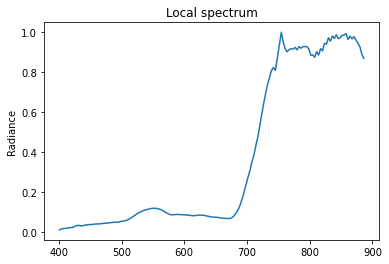

In [4]:
display_spectrum(data.reshape((95, 95, 156)), (50, 50))

In [5]:
def display_band(img, spectr_idx):
    
    """
    Display the image corresponding to the specified spectral band
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param spectr_idx: Indexof the spectral band to display
    :type loc: int
    
    """
    img_filtre = img[:,:,spectr_idx]
    plt.figure("Special band image")
    plt.title("Special band image")
    plt.gca().pcolormesh(img_filtre)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

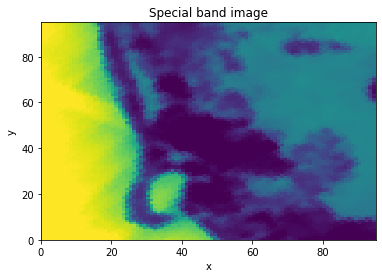

In [6]:
display_band(data.reshape((95, 95, 156)), 10)

## 2. Réduction de dimension

Les spectres observés dans les données sont des vecteurs de dimension $D = 156$ et peuvent donc être représentés dans l'espace vectoriel $\mathbb{R}^D$. Ces spectres correspondent cependant à la combinaison linéaire de $K = 3$ spectres élémentaires, pondérés par les quantités positives $\alpha _1$, $\alpha_2$ et $\alpha_3$, qui correspondent à la proportion relative de chacun des spectres élémentaires. Par ailleurs, on a la relation de liaison supplémentaire:

$$
\alpha_1 + \alpha_2 + \alpha_3 = 1.
$$

Compte tenu de ces différentes relations, est-il possible de réduire la dimension des données, c'est à dire de déterminer un sous-espace de $\mathbb{R}^D$ qui contienne l'ensemble des points de données ? Quelle serait la dimension de cet espace ? En utilisant l'algorithme d'analyse en composantes principales (ACP, ou PCA en anglais) présenté dans les slides accompagnant le mini-projet, identifier le sous-espace en question. Projeter les données spectrales dans ce sous-espace, et afficher le résultat. Commenter le résultat. En particulier, comment explique-t-on la distribution géométrique des données spectrales?


In [7]:
def pca(data, K):

    """
    Principal component analysis (PCA)
    """
    # Compute the covariance matrix and the mean of the data
    cov = np.cov(data.T)
    mean = np.mean(data)

    # Computes the eigenvalues/eigenvectors of the covariance matrix
    eival, eivec = eigh(cov)

    # Extract the K largest eigenvectors
    eival_max = eival[-K:]
    eivec_max = eivec[:, -K:]
    # Project the data on the subpasce spanned by the K largest eigenvectors
    Y = data - mean
    Y = Y @ eivec_max
    #Y = ...
    #return Y
    return Y

In [8]:
projected_data = pca(data, 2)

# 3. Détermination des spectres élémentaires

Dans l'espace de dimension réduite déterminé dans la question précédente, les données spectrales prennent la forme géométrique d'un simplexe. Les sommets de ce simplexe correspondent aux spectres élémentaires présents dans la scène. Implémenter l'algorithme N-FINDR décrit dans les slides accompagnant le mini-projet pour déterminer les spectres élémentaires.



In [9]:
class nfindr:

    """
    NFINDR algorithm implementation
    """

    def __init__(self, projected_data, R):

        """
        Constructor

        :param projected_data: Projected data points
        :param R: Number of endmembers
        :type projected_data: Numpy array 
        :type R: int
        """

        self.projected_data = projected_data
        self.N, self.K = self.projected_data.shape    
        self.R = R 


    def set_endmembers(self):

        """
        Initialize the NFINDR algorithm 
        """

        # Randomly select R endmembers from the data points
        
        rand_index = [np.random.randint(0, 9025) for k in range(self.R)]
        self.indexs = rand_index
        self.endmembers = self.projected_data[rand_index, :]
        first_point = self.endmembers[0, :]
        M = self.endmembers - first_point
        M = M[1:]

        # Compute the volume of the simplex
        self.V = np.abs(np.linalg.det(M))/factorial(self.R)

        

    def iterate(self):

        """
        N-FINDR Iteration
        """

        # Iterate over the endmembers
        for p in range(self.R):
            end = np.copy(self.endmembers)

            # Iterate over the data points
            for q in range(self.N):
                # Try replacing the selected endmember by the data point
                end[p,:] = self.projected_data[q, :]
                first_point = end[0, :]
                M = end - first_point
                M = M[1:]

                # Update the endmember if the volume is greater
                new_V = np.abs(np.linalg.det(M))/factorial(self.R)
                if new_V > self.V:
                    self.endmembers[p] = end[p]
                    self.V = new_V
                    self.indexs[p] = q



    def run(self):

        """
        Run the algorithm
        """

        # Randomly select endmembers within the data points
        self.set_endmembers()

        # Iterate until idempotence is reached
        flag = True
        while flag:
            end_cond = self.endmembers
            self.iterate()
            if np.array_equal(self.endmembers, end_cond):
                flag = False
  
        # Display result
        self.display_endmembers()
        self.original = data[self.indexs]
            

    def display_endmembers(self):

        """
        Scatter plot of the simplex data
        """
        print(self.endmembers)
        plt.scatter(self.endmembers[:,0], self.endmembers[:,1])
        plt.scatter(projected_data[:,0], projected_data[:, 1], s=1)
        plt.title("Simplex data")
        plt.show()
        



[[ 0.13458022 -2.61843203]
 [-1.68131994  2.76695322]
 [ 0.63868103  4.78032912]]


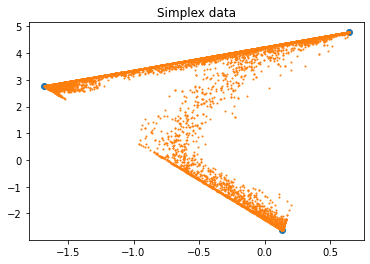

[0, 6449, 5167]


In [10]:
inst = nfindr(projected_data, R=3)
inst.run()
print(inst.indexs)

# 4. Détermination des abondances

Nous cherchons maintenant à identifier les abondances de chacun des spectres, c'est à dire à déterminer, en chaque point, quelle est la proportion relative de chacun des spectres élémentaires identifiés dans l'étape précédente. Pour ce faire, nous cherchons à résoudre, à chaque pixel de l'image, le problème d'optimisation suivant:

$$
\alpha := \arg \min \| Y[x, y] - \sum_{i = 1}^3 \alpha _{i}[x, y] m_i \|^2
$$

sous les contraintes 

$$
\forall i = 1,2,3, \quad \alpha_i \geq 0
$$

et 

$$
\sum_{i = 1}^3 \alpha_i = 1.
$$

Pour résoudre ce problème, appliquer un algorithme de descente de gradient projeté, tel que décrit dans les slides.

In [27]:
class projected_gradient:

    """
    Projected gradient descent implementation for solving
    minimize ||Ma - y||^2 s.t 0 <= a <= 1.
    """

    def __init__(self, M, y):

        """
        Constructor
        
        :param M: endmembers matrix
        :param y: spectra
        """
        
        self.M = M.T
        ones = np.ones(shape=(1, 3))
        self.M = np.concatenate((self.M, ones))
        self.D, self.R = self.M.shape
        self.y = y
        self.y = np.append(self.y, 1.)
        self.a = np.zeros(self.R)
        self.f = lambda a : norm(self.M @ self.a - self.y, ord = 2)
        self.alpha = 0.2
        self.beta = 0.1
        self.gamma = 0.9

    def iterate(self):

        """
        Iteration of the projected gradient descent algorithm
        """

        # Compute the gradient
        grad_J = 2*np.dot(self.M.T, self.M @ self.a - self.y)
        next = True
        t = 1
        a_copy = self.a
        while(next):
            # Proximal operator
            droite = self.f(a_copy) - self.alpha*t*np.power(np.linalg.norm(grad_J), 2)
            droite_bis = self.gamma*np.power(np.linalg.norm(grad_J), 2)
            print(t)
            a_copy -= t*grad_J
            gauche = self.f(a_copy)
            grad_J_copy = 2*np.dot(self.M.T, self.M @ a_copy - self.y)
            gauche_bis = np.power(np.linalg.norm(grad_J_copy), 2)
            t *= self.beta
            # Line search
            if  (gauche <= droite) and (gauche_bis >= droite_bis):
                next = False
                
        self.a = a_copy
        self.a[self.a < 0] = 0
        self.a[self.a > 1] = 1
        self.grad_J = grad_J
                

    def run(self, eps, maxiter):

        """
        Run the proximal gradient algorithm

        :param eps: Requested precision 
        :param maxiter: Maximal number of iteration
        """
        iter = 0
        while iter < maxiter:
            self.iterate()
            iter += 1
            if np.linalg.norm(self.grad_J) <= eps:
                return self.a    

In [ ]:
test = projected_gradient(inst.original, data[3000, :])
rep = test.run(0.01, 100000)
print(rep)
print(sum(rep))

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.000100

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.00100

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.00000000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.000000

0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000

1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.0000000

1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.000000

1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.00000

1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.000000

1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.000000

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.00000000

1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000

1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.000000

In [19]:
def display_abundances(abundances):

    """
    Display the abundances maps

    :param abundances: Abundances map
    :type abunbances: Numpy array
    """
    shape = abundances.shape
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            print(i, j)            
            pix = data[i*shape[0] + j]
            proj = projected_gradient(inst.original, pix)
            ab_pix = proj.run(0.01, 10000)
            abundances[i, j] = ab_pix
            
    plt.figure("Abundances map")
    plt.title("Abundances map")
    plt.gca().pcolormesh(abundances)
    plt.show()


In [22]:
# Abundances estimation
endmembers = inst.endmembers
N, D = projected_data.shape

R = D + 1 # Number of endmembers
abundances = np.zeros((N, R))
    
# Trick for handling the sum-to-one constraint (see slides)

display_abundances(abundances.reshape((95, 95, 3)))

 28
59 29
59 30
59 31
59 32
59 33
59 34
59 35
59 36
59 37
59 38
59 39
59 40
59 41
59 42
59 43
59 44
59 45
59 46
59 47
59 48
59 49
59 50
59 51
59 52
59 53
59 54
59 55
59 56
59 57
59 58
59 59
59 60
59 61
59 62
59 63
59 64
59 65
59 66
59 67
59 68
59 69
59 70
59 71
59 72
59 73
59 74
59 75
59 76
59 77
59 78
59 79
59 80
59 81
59 82
59 83
59 84
59 85
59 86
59 87
59 88
59 89
59 90
59 91
59 92
59 93
59 94
60 0
60 1
60 2
60 3
60 4
60 5
60 6
60 7
60 8
60 9
60 10
60 11
60 12
60 13
60 14
60 15
60 16
60 17
60 18
60 19
60 20
60 21
60 22
60 23
60 24
60 25
60 26
60 27
60 28
60 29
60 30
60 31
60 32
60 33
60 34
60 35
60 36
60 37
60 38
60 39
60 40
60 41
60 42
60 43
60 44
60 45
60 46
60 47
60 48
60 49
60 50
60 51
60 52
60 53
60 54
60 55
60 56
60 57
60 58
60 59
60 60
60 61
60 62
60 63
60 64
60 65
60 66
60 67
60 68
60 69
60 70
60 71
60 72
60 73
60 74
60 75
60 76
60 77
60 78
60 79
60 80
60 81
60 82
60 83
60 84
60 85
60 86
60 87
60 88
60 89
60 90
60 91
60 92
60 93
60 94
61 0
61 1
61 2
61 3
61 4
61 5
61 6
61 7


ValueError: too many values to unpack (expected 2)

In [23]:
print(abundances)

[[9.99834364e-01 1.43049433e-04 0.00000000e+00]
 [9.99834364e-01 1.43049433e-04 0.00000000e+00]
 [9.99834364e-01 1.43049433e-04 0.00000000e+00]
 ...
 [           nan            nan            nan]
 [           nan            nan            nan]
 [           nan            nan            nan]]
